In [131]:
# !pip install transformers --upgrade
!pip install resampy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 18.3 MB/s eta 0:00:00


# Question 1:  Speech Emotion Recognition on shEMO dataset using HuBERT

**HuBERT** leverages the masked prediction loss over sequences, e.g.,
Google’s Bidirectional Encoder Representations from Transformers, or BERT, method, to represent the sequential structure of speech. HuBERT uses an offline clustering step to generate noisy labels for Masked Language Model pretraining. Concretely, HuBERT consumes masked continuous speech features to predict predetermined cluster assignments. The predictive loss is applied over only the masked regions, forcing the model to learn good high-level representations of unmasked inputs in order to infer the targets of masked ones correctly.

The official [paper](https://arxiv.org/pdf/2106.07447.pdf).




In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import librosa
import os
import seaborn as sns
from sklearn.model_selection import train_test_split

import shutil
from google.colab import drive
from google.colab import files


## 1-3. Pre-processing

In [80]:
uploaded = files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mansourehk/shemo-persian-speech-emotion-detection-database
!unzip -q shemo-persian-speech-emotion-detection-database.zip

Saving kaggle.json to kaggle.json
shemo-persian-speech-emotion-detection-database.zip: Skipping, found more recently modified local copy (use --force to force download)
replace female/F01A01.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace female/F01A02.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace female/F01A03.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: nA
replace female/F01A04.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [81]:
male_folder = "./male/"
female_folder = "./female/"

In [82]:
def extract_features(folder):
    features = []
    for filename in os.listdir(folder):
        if filename.endswith(".wav"):
            file_path = os.path.join(folder, filename)
            # Load the audio file
            audio, sr = librosa.load(file_path, sr=None)
            print(f"Processing {filename}: Sampling Rate - {sr}, Shape - {audio.shape}")
            emotion = filename[3]
            # Compute statistical features
            duration = len(audio) / sr
            print(f"Duration: {duration} seconds")
            mean = audio.mean()
            std = audio.std()
            features.append([filename, emotion, duration, mean, std])
    return features

In [83]:
male_features = extract_features(male_folder)
female_features = extract_features(female_folder)

Streaming output truncated to the last 5000 lines.
Processing M22A01.wav: Sampling Rate - 44100, Shape - (107916,)
Duration: 2.4470748299319727 seconds
Processing M22A04.wav: Sampling Rate - 44100, Shape - (116458,)
Duration: 2.6407709750566895 seconds
Processing M04N48.wav: Sampling Rate - 44100, Shape - (427186,)
Duration: 9.686757369614513 seconds
Processing M12A30.wav: Sampling Rate - 44100, Shape - (234147,)
Duration: 5.309455782312925 seconds
Processing M28N06.wav: Sampling Rate - 44100, Shape - (83041,)
Duration: 1.883015873015873 seconds
Processing M40N41.wav: Sampling Rate - 44100, Shape - (321459,)
Duration: 7.289319727891156 seconds
Processing M24S02.wav: Sampling Rate - 44100, Shape - (258203,)
Duration: 5.854943310657596 seconds
Processing M03A45.wav: Sampling Rate - 44100, Shape - (168165,)
Duration: 3.813265306122449 seconds
Processing M28A12.wav: Sampling Rate - 44100, Shape - (259888,)
Duration: 5.893151927437642 seconds
Processing M29A08.wav: Sampling Rate - 44100, Sh

In [84]:
all_features = male_features + female_features
all_df = pd.DataFrame(all_features, columns=["Filename", "Emotion", "Duration", "Mean", "Std"])


In [85]:
print("all_df Statistics:")
print(all_df.describe())

all_df Statistics:
          Duration          Mean          Std
count  3000.000000  3.000000e+03  3000.000000
mean      4.111796 -4.917908e-05     0.068586
std       3.414900  7.159096e-04     0.003826
min       0.358617 -1.997973e-02     0.058740
25%       1.955108 -6.370426e-06     0.066007
50%       3.079626 -4.609616e-07     0.067644
75%       5.104076  4.195887e-06     0.070112
max      33.328005  9.773192e-04     0.108408


* A: anger emotion
* F: female speaker (if used at the beginning of the label e.g.F14A09) or fear (if used in the middle of the label e.g. M02F01)
* H : happiness
* M : male speaker
* N : neutral
* S : sadness
* W : surprise

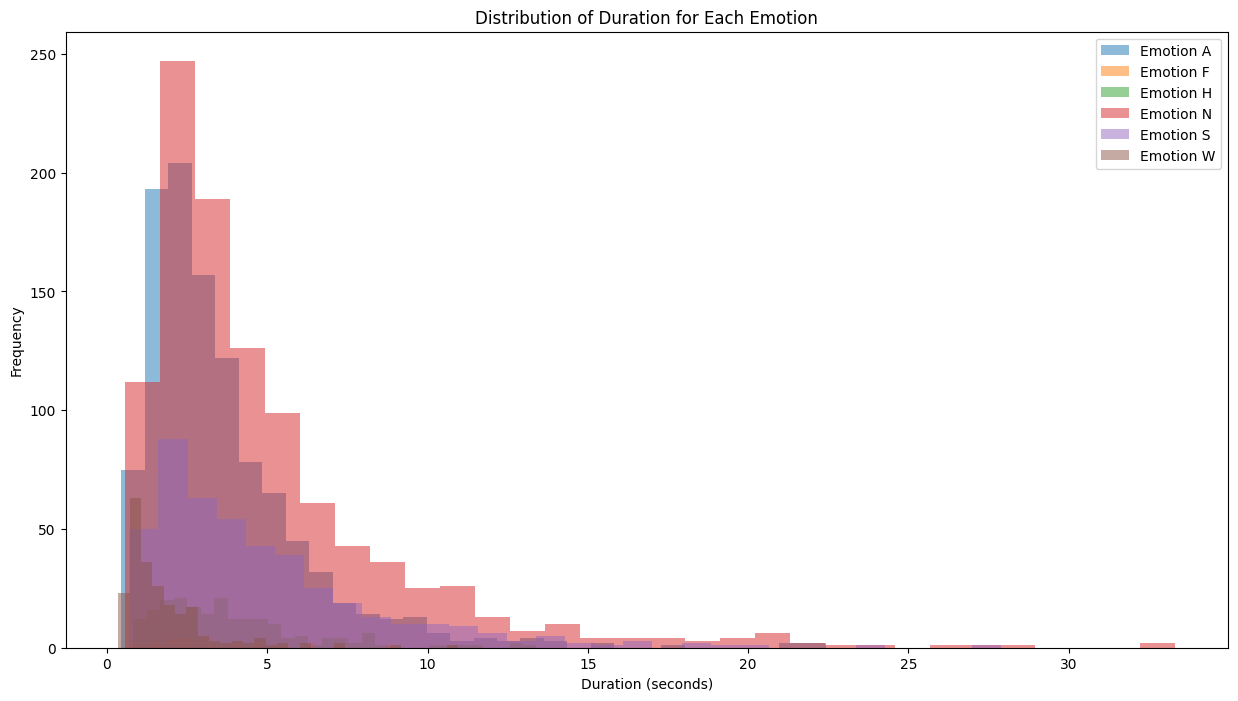

In [86]:
emotions = ["A", "F", "H", "N", "S", "W"]
plt.figure(figsize=(15, 8))
for emotion in emotions:
    emotion_data = all_df[all_df["Emotion"] == emotion]
    plt.hist(emotion_data["Duration"], bins=30, alpha=0.5, label=f"Emotion {emotion}")

plt.title("Distribution of Duration for Each Emotion")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

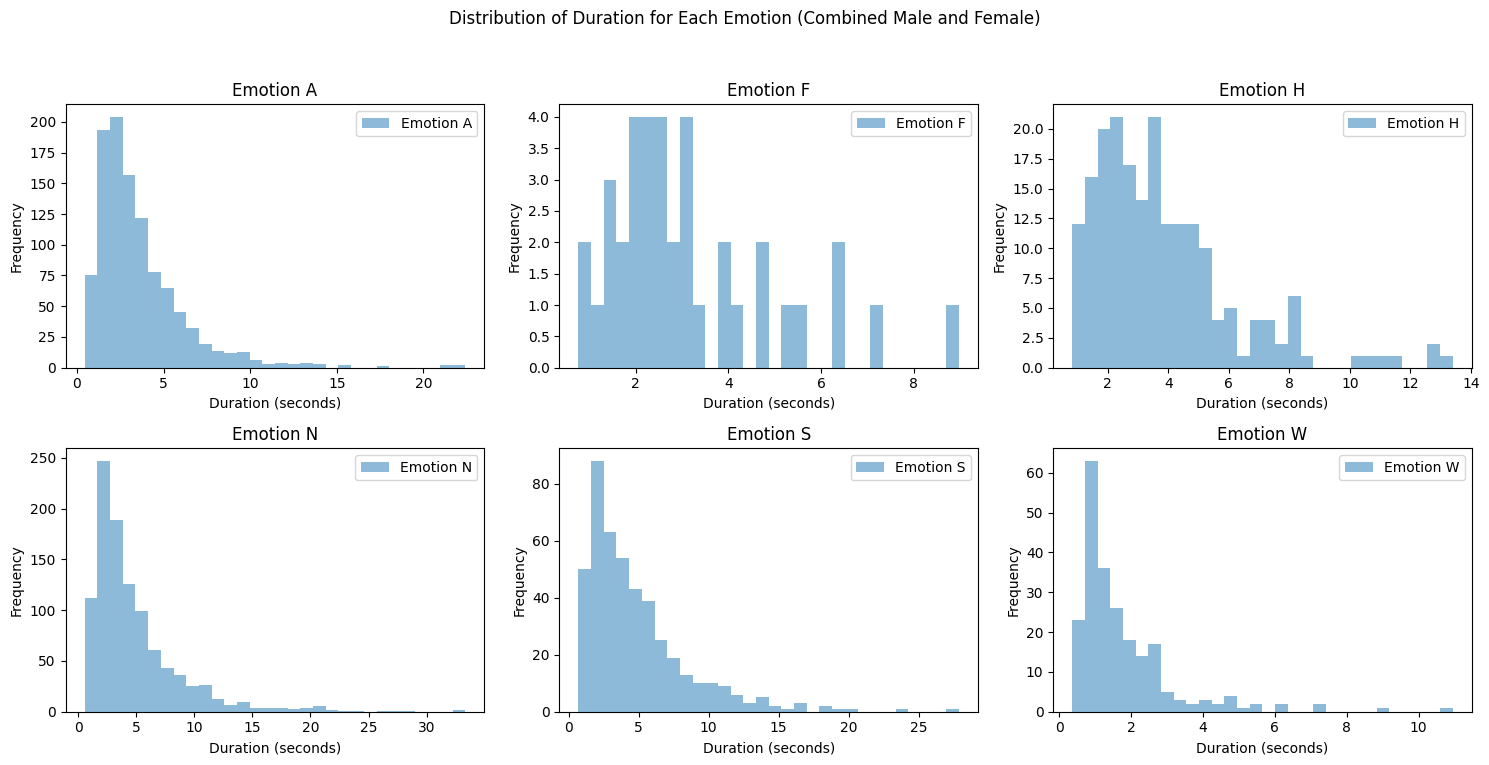

In [87]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
fig.suptitle("Distribution of Duration for Each Emotion (Combined Male and Female)")

for ax, emotion in zip(axes.flatten(), emotions):
    emotion_data = all_df[all_df["Emotion"] == emotion]
    ax.hist(emotion_data["Duration"], bins=30, alpha=0.5, label=f"Emotion {emotion}")
    ax.set_title(f"Emotion {emotion}")
    ax.set_xlabel("Duration (seconds)")
    ax.set_ylabel("Frequency")
    ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

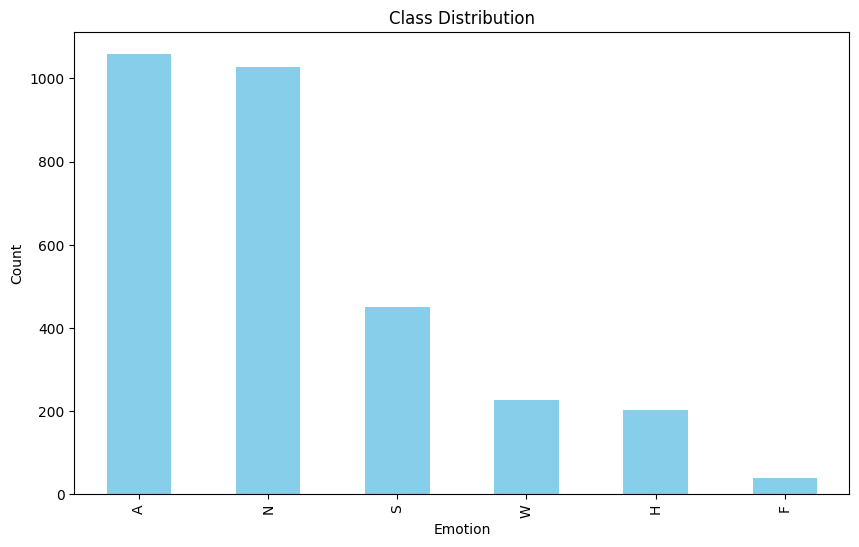

Class Distribution:
A    1059
N    1028
S     449
W     225
H     201
F      38
Name: Emotion, dtype: int64


In [88]:
class_distribution = all_df["Emotion"].value_counts()

plt.figure(figsize=(10, 6))
class_distribution.plot(kind="bar", color="skyblue")
plt.title("Class Distribution")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.show()
print("Class Distribution:")
print(class_distribution)

We can see the data is imbalance in specific emotion classes.

We have possible solutions to solve the problem

We can do data augmentation, under-sampling, Oversampling and so on.

In [89]:
all_df

,Filename,Emotion,Duration,Mean,Std
0,M12N57.wav,N,10.562721,-5.571127e-05,0.064490
1,M12W09.wav,W,2.141202,2.491772e-06,0.073849
2,M22N12.wav,N,3.563855,1.003861e-05,0.068249
3,M27A02.wav,A,3.183900,-2.477312e-06,0.068179
4,M17N05.wav,N,6.544467,1.676447e-05,0.065166
...,...,...,...,...,...
2995,F31A01.wav,A,2.395510,1.644867e-06,0.068133
2996,F21A17.wav,A,1.789070,-6.478865e-07,0.069883
2997,F30N05.wav,N,1.240045,3.129606e-05,0.073774
2998,F24A40.wav,A,3.501587,7.772476e-06,0.066800


In [90]:
import torchaudio
import librosa
import IPython.display as ipd
import numpy as np

idx = np.random.randint(0, len(all_df))
sample = all_df.iloc[idx]
Filename = sample["Filename"]
label = sample["Emotion"]


print(f"ID Location: {idx}")
print(f"      Label: {label}")
print()

if(Filename[0] == 'M'):
  path = './male/'+sample['Filename']
else:
  path = './female/'+sample['Filename']

print(path)
speech, sr = torchaudio.load(path)
speech = speech[0].numpy().squeeze()


ID Location: 1663
      Label: A

./male/M41A04.wav


In [91]:
save_path = "./"

train_df , test_temp_df = train_test_split(all_df, test_size=0.2, random_state=101, stratify=all_df["Emotion"])

val_df , test_df = train_test_split(test_temp_df, test_size=0.5, random_state=101, stratify=test_temp_df["Emotion"])

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train_df.to_csv(f"{save_path}/train.csv", sep="\t", encoding="utf-8", index=False)
test_df.to_csv(f"{save_path}/test.csv", sep="\t", encoding="utf-8", index=False)
val_df.to_csv(f"{save_path}/validation.csv", sep="\t", encoding="utf-8", index=False)

print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(2400, 5)
(300, 5)
(300, 5)


In [92]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import pandas as pd

X = all_df[["Duration", "Mean", "Std"]]
y = all_df["Emotion"]

In [93]:
X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

total_samples = len(all_df)
train_samples = len(X_train_temp)
val_samples = len(X_val)
test_samples = len(X_test)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_temp, y_train_temp)



resampled_train_samples = len(X_train_resampled)


print("Total Samples:", total_samples)
print("\nTraining Set Samples:", resampled_train_samples)
print("Validation Set Samples:", val_samples)
print("Testing Set Samples:", test_samples)

print("Training Set Class Distribution:")
print(pd.Series(y_train_resampled).value_counts(normalize=True))

print("\nValidation Set Class Distribution:")
print(pd.Series(y_val).value_counts(normalize=True))

print("\nTesting Set Class Distribution:")
print(pd.Series(y_test).value_counts(normalize=True))


Total Samples: 3000

Training Set Samples: 5082
Validation Set Samples: 300
Testing Set Samples: 300
Training Set Class Distribution:
W    0.166667
H    0.166667
A    0.166667
N    0.166667
S    0.166667
F    0.166667
Name: Emotion, dtype: float64

Validation Set Class Distribution:
A    0.353333
N    0.343333
S    0.150000
W    0.076667
H    0.066667
F    0.010000
Name: Emotion, dtype: float64

Testing Set Class Distribution:
A    0.353333
N    0.343333
S    0.150000
W    0.073333
H    0.066667
F    0.013333
Name: Emotion, dtype: float64


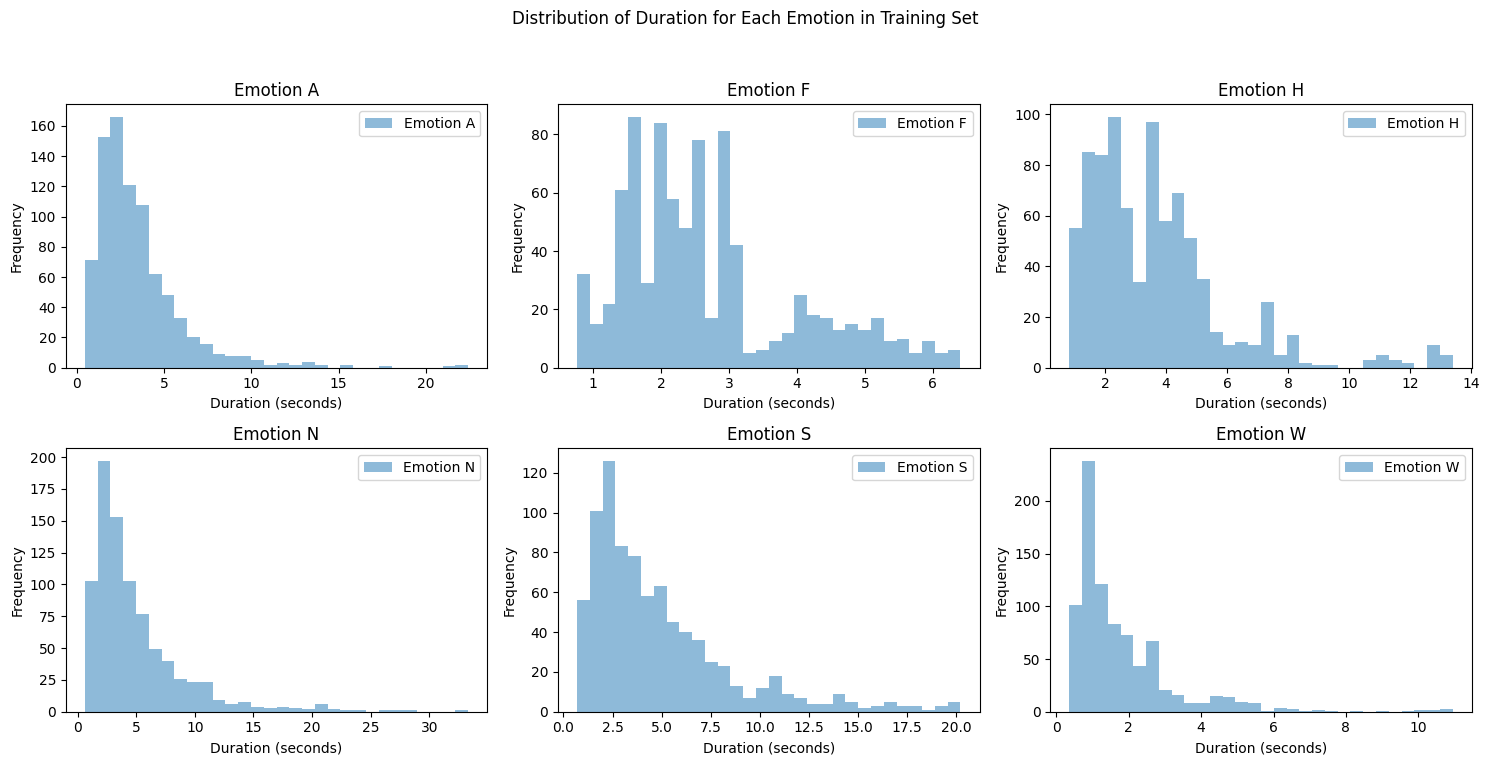

In [94]:
emotions = ["A", "F", "H", "N", "S", "W"]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
fig.suptitle("Distribution of Duration for Each Emotion in Training Set")

for ax, emotion in zip(axes.flatten(), emotions):
    emotion_data = X_train_resampled[y_train_resampled == emotion]
    ax.hist(emotion_data["Duration"], bins=30, alpha=0.5, label=f"Emotion {emotion}")
    ax.set_title(f"Emotion {emotion}")
    ax.set_xlabel("Duration (seconds)")
    ax.set_ylabel("Frequency")
    ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

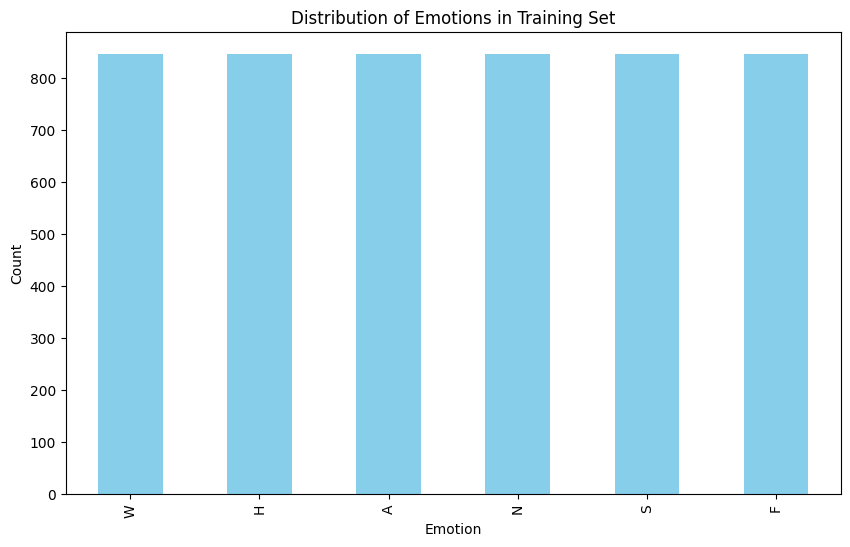

In [95]:
plt.figure(figsize=(10, 6))
pd.Series(y_train_resampled).value_counts().plot(kind="bar", color="skyblue")
plt.title("Distribution of Emotions in Training Set")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.show()

In [96]:
train_df.head()


,Filename,Emotion,Duration,Mean,Std
0,M18N15.wav,N,4.751066,-7.104387e-06,0.065822
1,M16A22.wav,A,4.080454,-6.164467e-06,0.066188
2,M29A11.wav,A,5.073878,3.902155e-06,0.066451
3,M16H06.wav,H,1.988980,-8.458665e-06,0.069387
4,F30A03.wav,A,3.236259,6.021448e-07,0.067977


In [97]:
val_df.head()


,Filename,Emotion,Duration,Mean,Std
0,M14S02.wav,S,1.381111,-0.000017,0.074136
1,M12A28.wav,A,0.643129,0.000008,0.080370
2,F03S18.wav,S,0.979773,0.000046,0.075489
3,M40N53.wav,N,7.233651,-0.000032,0.065187
4,F07S44.wav,S,2.577642,-0.000019,0.070545


In [98]:
test_df.head()

,Filename,Emotion,Duration,Mean,Std
0,M04N06.wav,N,9.794603,-2.333537e-05,0.064537
1,M47A15.wav,A,6.652449,8.216787e-07,0.065200
2,F21W06.wav,W,2.794762,-1.930609e-06,0.068387
3,F21N02.wav,N,4.485397,-4.182077e-06,0.065882
4,M22A02.wav,A,2.637891,-5.479633e-06,0.068208


In [99]:
input_column = "Filename"
output_column = "Emotion"

In [100]:
label_list = train_df["Emotion"].unique()
label_list.sort()
num_labels = len(label_list)
print(f"A classification problem with {num_labels} classes: {label_list}")

A classification problem with 6 classes: ['A' 'F' 'H' 'N' 'S' 'W']


### 1-3-2 Dataloader

`pad_collate` is a custom collate function that uses `pad_sequence` to pad sequences in a batch to have the same length as the `longest sequence` in that `batch`

Now, let's compare this method with the method that doubles the length of all sequences in the dataset by a certain value with padding:

---

Advantages and disadvantages of the method that pads each `batch separately`:

Advantages:

* Minimizes wasted computation: Only pads sequences in a batch to the length of the longest sequence in that specific batch, minimizing unnecessary computation.
* More memory-efficient: Reduces memory consumption compared to padding all sequences to the length of the longest sequence in the entire dataset.

Disadvantages:

* Variable batch size: Different batches may have different sizes, leading to variable computation times for different batches.

---

Advantages and disadvantages of the method that pads all sequences to the length of the longest sequence in the dataset:

Advantages:

* Fixed batch size: All batches have the same size, simplifying the training process.
* Consistent computation time: All batches take the same amount of time to process, making it easier to estimate training times.

Disadvantages:

* Increased memory usage: Padding all sequences to the length of the longest sequence in the dataset may lead to increased memory consumption, especially for datasets with long sequences.
* Potentially wasteful computation: Some computation may be wasted on padding when sequences in a batch are shorter than the maximum length.

In [101]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

In [102]:
class ShEMODataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return torch.tensor(self.features[index]), torch.tensor(self.labels[index])

In [103]:
train_dataset = ShEMODataset(X_train_resampled, y_train_resampled)
validation_dataset = ShEMODataset(X_val, y_val)
test_dataset = ShEMODataset(X_test, y_test)

In [104]:
def pad_collate(batch):
    sequences, labels = zip(*batch)
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0)
    return padded_sequences, torch.tensor(labels)

In [105]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=pad_collate)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=True, collate_fn=pad_collate)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, collate_fn=pad_collate)

## Feature Extraction

In [106]:
train_df['Audio_Path'] = train_df.apply(lambda row: f"./male/{row['Filename']}" if row['Filename'][0] == 'M' else f"./female/{row['Filename']}", axis=1)
val_df['Audio_Path'] = val_df.apply(lambda row: f"./male/{row['Filename']}" if row['Filename'][0] == 'M' else f"./female/{row['Filename']}", axis=1)
test_df['Audio_Path'] = test_df.apply(lambda row: f"./male/{row['Filename']}" if row['Filename'][0] == 'M' else f"./female/{row['Filename']}", axis=1)

In [118]:
train_df.head()

,Filename,Emotion,Duration,Mean,Std,Audio_Path
0,M18N15.wav,N,4.751066,-7.104387e-06,0.065822,./male/M18N15.wav
1,M16A22.wav,A,4.080454,-6.164467e-06,0.066188,./male/M16A22.wav
2,M29A11.wav,A,5.073878,3.902155e-06,0.066451,./male/M29A11.wav
3,M16H06.wav,H,1.988980,-8.458665e-06,0.069387,./male/M16H06.wav
4,F30A03.wav,A,3.236259,6.021448e-07,0.067977,./female/F30A03.wav


In [117]:
import librosa
import librosa.display
import IPython.display as ipd

In [153]:
ipd.Audio("./male/M18N15.wav")

In [154]:
def feature_extraction(file_path):
    # Loading audio file
    audio, sample_rate = librosa.load(file_path, res_type="kaiser_fast")

    # Extracting features
    mfcc = np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=50).T, axis=0)
    return mfcc

In [158]:
features = {}
features["./male/M18N15.wav"] = feature_extraction("./male/M18N15.wav")
features["./male/M18N15.wav"],len(features["./male/M18N15.wav"])

(array([-2.72741089e+02,  1.01949188e+02,  1.79669309e+00,  1.45551319e+01,
         1.19684095e+01,  6.84980583e+00, -6.25742722e+00,  1.05250692e+01,
        -1.77790890e+01, -5.30331993e+00, -8.23155403e+00,  7.07170534e+00,
        -8.23663902e+00, -1.07273877e+00,  2.12770915e+00,  7.57013130e+00,
        -8.49742985e+00,  6.94123840e+00, -6.41694117e+00,  7.43618870e+00,
        -1.33227797e+01,  4.07834291e+00, -9.18372631e+00,  1.37602818e+00,
        -4.10874987e+00,  1.16461575e+00, -3.20553994e+00,  2.79366374e+00,
        -3.13340878e+00,  4.51998758e+00, -3.80510187e+00,  4.12713038e-03,
         1.12833835e-01, -1.14594531e+00, -3.56837249e+00, -2.20911574e+00,
        -8.92761528e-01,  1.41275868e-01, -4.08895159e+00, -5.18929422e-01,
        -1.67989814e+00, -8.94287705e-01, -1.81087053e+00, -1.57512176e+00,
        -2.12968183e+00, -8.86015058e-01, -2.70850331e-01, -5.88744879e-01,
        -1.47377348e+00, -9.84128654e-01], dtype=float32),
 50)

In [168]:
features_list = []

samples_to_process = train_df.head(1)
for index, row in samples_to_process.iterrows():
    file_path = row['Audio_Path']
    features  = feature_extraction(file_path)
    features_list.append({'file_path': file_path, 'features': features, 'label': row['Emotion']})

features_list

features2  = feature_extraction("./male/M16A22.wav")

ModuleNotFoundError: ignored

## Problem description
### 1-4-1. Generating valid representation of the world

Indeed, unlike models based on text transformers like BERT, HuBERT, being designed for speech signals, doesn't generate a single embedding vector for the entire input sequence. Instead, it typically provides embeddings for smaller contextual chunks or frames of the input audio. To create a fixed-size representation for the entire input sequence, we can aggregate these embeddings using pooling or similar techniques.

One common approach is to use mean pooling or max pooling across the temporal dimension to obtain a fixed-size representation

* `Mean Pooling`: Taking the mean across the temporal dimension helps capture the average information from the entire sequence. This can be useful when the emotion information is distributed across the entire utterance.

* `Max Pooling`: Taking the maximum value across the temporal dimension emphasizes the most salient features in the sequence. This can be helpful when the emotion is conveyed through specific key moments in the speech.


In [108]:
# from transformers import AutoProcessor, HubertModel
# from transformers import Wav2Vec2FeatureExtractor
# import torchaudio
# import torchaudio.transforms as T
# target_sampling_rate = 16000

In [109]:
#
# model_name_or_path = "facebook/hubert-base-ls960"
# model = HubertModel.from_pretrained(model_name_or_path)
# feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name_or_path)
#

In [110]:
# def preprocess_audio(row):
#     path = row['Audio_Path']
#     speech_array, sampling_rate = torchaudio.load(path)
#     inputs = feature_extractor(speech_array.squeeze().numpy(), return_tensors="pt")
#     return inputs

In [111]:
# def generate_representation(model, inputs, pooling_mode="mean"):
#     outputs = model(**inputs)
#     last_hidden_states = outputs.last_hidden_state
#
#     if pooling_mode == "mean":
#         representation = last_hidden_states.mean(dim=1)
#     elif pooling_mode == "max":
#         representation = last_hidden_states.max(dim=1).values
#     else:
#         raise ValueError(f"Pooling mode {pooling_mode} not supported.")
#
#     return representation


In [112]:
# row_example = train_df.iloc[0]
# inputs_example = preprocess_audio(row_example)
# representation_example = generate_representation(model, inputs_example, "mean")
# print(representation_example)
# print(f"Training labels: {train_df.iloc[0]['Emotion']}")

### 1-4-2. Train model

In [113]:
# from sklearn.metrics import confusion_matrix, classification_report
# from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import train_test_split
# from sklearn.svm import SVC

In [114]:
# label_encoder = LabelEncoder()
# train_df['Label'] = label_encoder.fit_transform(train_df['Emotion'])
# val_df['Label'] = label_encoder.transform(val_df['Emotion'])
# test_df['Label'] = label_encoder.transform(test_df['Emotion'])

In [115]:
# X_train = train_df['Audio_Path']
# y_train = train_df['Label']
#
# X_val = val_df['Audio_Path']
# y_val = val_df['Label']
#
# X_test = test_df['Audio_Path']
# y_test = test_df['Label']

In [116]:
# # Convert labels to numpy arrays
# y_train = y_train.to_numpy()
# y_val = y_val.to_numpy()
# y_test = y_test.to_numpy()
#